# Gel band Migration Distance (cm)
Takes picture of lanes from Gel Electrophoresis to find the Migration Distance to estimate MW of bands

This analysis was done of the pGEM-Luc plasmid on 1.1% Agarose

Lanes from left to right: 1kB NEB Ladder, Native Plasmid, EcoRI Treatment, Topoisomerase Treatment

### Imports

In [1]:
! pip install opencv-python
! pip install pillow

In [2]:
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image as ImageP
from PIL import ImageFont, ImageDraw

### Converting Image to Grayscale and make pixels into numpy array

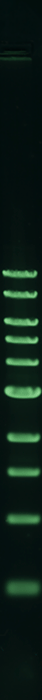

In [3]:
Ladder_path = 'Ladder.png'
image = cv2.imread(Ladder_path)

#BGR to Grayscale
g_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Image(filename= Ladder_path)

### Finding cutoff Level for noise

In [4]:
rowmean = g_img.mean(axis=1) #averaging pixel values across columns 
Max = rowmean.max()
Min = rowmean.min()

Level = (Max - Min)/4 #cutoff for signal vs noise

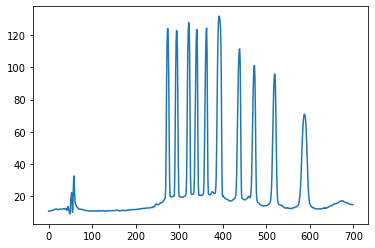

In [5]:
plt.plot(rowmean)
plt.show()

### Moving Average function and Interpolation
Interpolation is used to smooth out the curve while the moving average is used to increase signal to noise ratio

In [6]:
#Moving average function using cumsum from numpy
def moving_avg(x,n):
    cumsum = np.cumsum(np.insert(x,0,0))
    return (cumsum[n:] - cumsum[:-n])/ float(n)

In [7]:
moving_avg(rowmean,5).shape

(696,)

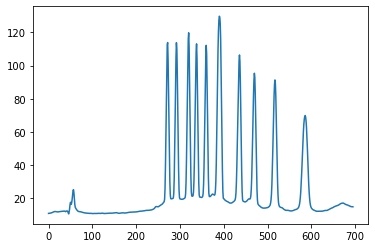

In [8]:
from scipy.interpolate import interp1d

#Applying the interpolation to the moving average
inter = interp1d(range(len(moving_avg(rowmean,5))), moving_avg(rowmean,5))

plt.plot(inter(range(696)))
plt.show()

### Finding bands and converting from pixels to cm

In [9]:
from scipy.signal import find_peaks
peaks = find_peaks(inter(range(696)), height = Level) #finding peaks above Level and returning indexes

In [10]:
travelpx = peaks[0] #indexes for peaks
travelcm = (7.0/len(rowmean)) * travelpx #converts from avg pixel value to cm
bp = [10000.,8000.,6000.,5000.,4000.,3000.,2000.,1500.,1000.,500.]
travelbp = np.log10(bp) #base pair lengths of ladder bands

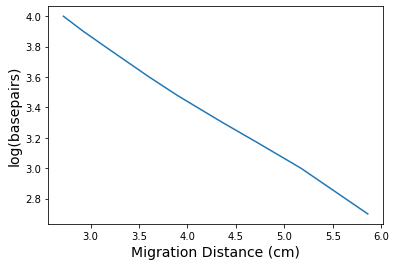

In [11]:
plt.plot(travelcm, travelbp)
plt.xlabel('Migration Distance (cm)', fontsize = 14)
plt.ylabel('log(basepairs)', fontsize = 14)
plt.show()

In [12]:
Ladder_Table = pd.concat([pd.DataFrame(bp, columns = ['Ladder_MW']), pd.DataFrame(travelcm, columns = ['Migration_Distance'])], axis = 1)
Ladder_Table

,Ladder_MW,Migration_Distance
0,10000.0,2.72
1,8000.0,2.92
2,6000.0,3.20
3,5000.0,3.38
4,4000.0,3.60
5,3000.0,3.90
6,2000.0,4.36
7,1500.0,4.70
8,1000.0,5.17
9,500.0,5.86


### Linear Regression to evaluate effectiveness of Fit

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(travelcm.reshape((-1,1)),travelbp.reshape((-1,1)))

In [14]:
r_sq = model.score(travelcm.reshape((-1,1)),travelbp.reshape((-1,1)))
print('coefficient of determination:', r_sq)
print('Regression equation: y = ',model.coef_,'x + ',model.intercept_)

coefficient of determination: 0.998814638579526
Regression equation: y =  [[-0.40661676]] x +  [5.0822897]


   Ladder_MW  Regression  Residuals
0    10000.0        9468        532
1     8000.0        7851        149
2     6000.0        6041        -41
3     5000.0        5104       -104
4     4000.0        4154       -154
5     3000.0        3136       -136
6     2000.0        2039        -39
7     1500.0        1483         17
8     1000.0         955         45
9      500.0         500          0


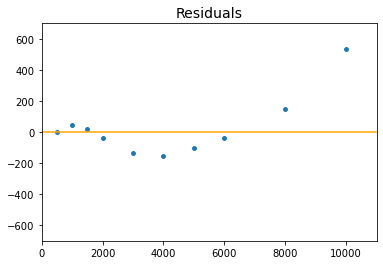

In [15]:
#Residual analysis of regression line
Reg = pd.DataFrame(range(10),columns = ['Regression'])
for i in range(10):
    Reg['Regression'][i] = (10**(model.coef_ * Ladder_Table['Migration_Distance'][i] + model.intercept_))

Res = pd.DataFrame(range(10),columns = ['Residuals'])
for i in range(10):
    Res['Residuals'][i] = Ladder_Table['Ladder_MW'][i] - Reg['Regression'][i]
    
Residuals = pd.concat([pd.DataFrame(bp, columns = ['Ladder_MW']), pd.DataFrame(Reg, columns = ['Regression']), pd.DataFrame(Res,columns = ['Residuals'])], axis = 1)
print(Residuals)

plt.scatter(Residuals['Ladder_MW'], Residuals['Residuals'], s = 15)
plt.plot([-1,0,1,2,100,10000,11000],[0 for i in range(7)], color = 'orange')
plt.xlim(0,11000)
plt.ylim(-700,700)
plt.title('Residuals', fontsize = 14)
plt.show()

### Using Ladder to extrapolate migration distance the rest of Lanes

In [16]:
def AnnotateLanes(x,name):
    image = cv2.imread(x)

    #BGR to Grayscale
    g_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rowmean = g_img.mean(axis=1) #averaging pixel values across columns 
    Max = rowmean.max()
    Min = rowmean.min()

    Level = (Max - Min)/4 #cutoff for signal vs noise

    moving_avg(rowmean,5).shape

    #Applying the interpolation to the moving average
    inter = interp1d(range(len(moving_avg(rowmean,5))), moving_avg(rowmean,5))

    peaks = find_peaks(inter(range(696)), height = Level) #finding peaks above Level and returning indexes

    travelpx = peaks[0] #indexes for peaks
    travelcm = (7.0/len(rowmean)) * travelpx #converts from avg pixel value to cm
    
    logbp = (model.coef_ * travelcm) + model.intercept_
    ind = logbp.shape
    
    table = pd.concat([pd.DataFrame((10**logbp.reshape((ind[1],ind[0]))), columns = ['MW']), pd.DataFrame(travelcm, columns = ['Migration_Distance'])], axis = 1)
    
    path = x

    pathImg = ImageP.open(path)
    for i in range(len(table)):
        text = str(int(table['MW'][i]))
        times_new_roman = ImageFont.truetype('times-new-roman.ttf',12)
        pathImg_editable = ImageDraw.Draw(pathImg)
        Px = table['Migration_Distance'] * len(rowmean) / 7
        pathImg_editable.text((8,Px[i]), text, (237,230,211), font = times_new_roman)
        naming = 'Annotate'+name+'.png'
        pathImg.save(naming)
        pathImg = ImageP.open(naming)
    
    pathImg_editable = ImageDraw.Draw(pathImg)
    pathImg_editable.text((5,20), name, (237,230,211), font = times_new_roman)
    pathImg.save(naming)

In [17]:
#Ladder annotation
def Annotate(path,table,name):
    pathImg = ImageP.open(path)
    for i in range(len(table)):
        text = str(int(table['Ladder_MW'][i]))
        font_t = ImageFont.truetype('times-new-roman.ttf',12)
        pathImg_editable = ImageDraw.Draw(pathImg)
        Px = Ladder_Table['Migration_Distance'] * len(rowmean) / 7
        pathImg_editable.text((8,Px[i]), text, (237,230,211), font = font_t )
        naming = 'Annotate'+name+'.png'
        pathImg.save(naming)
        pathImg = ImageP.open(naming)
    pathImg_editable = ImageDraw.Draw(pathImg)
    pathImg_editable.text((5,20), 'Ladder', (237,230,211), font = font_t)
    pathImg.save(naming)

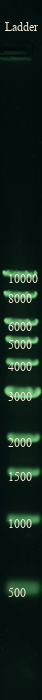

In [18]:
Annotate(Ladder_path,Ladder_Table,'LADDER')
Image(filename = 'AnnotateLADDER.png')

### Using Ladder Regression Line to estimate MW of bands in other lanes
1. Control lane: (Circular nicked plasmid and Supercoiled plasmid)

 Issues: Simple average for cutoff of signal/noise causes slightly fainter bands to be missed

2. ECORI: EcoRI treatment (2 EcoRI sites on plasmid)

 Issues: Contaminants fluoresced more than bands and were counted as a band

3. TOPO1: Topoisomerase 1 treatment

 Issues: Contaminant fluoresced more and were counted as a band

#### Control

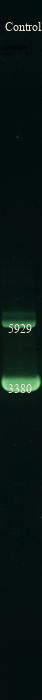

In [19]:
Control_lane = 'Control_lane.png'
AnnotateLanes(Control_lane, 'Control')
Image(filename = 'AnnotateControl.png')

#### Topoisomerase 1

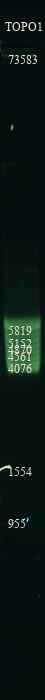

In [20]:
TOPO1_lane = 'TOPO1_lane.png'
AnnotateLanes(TOPO1_lane, 'TOPO1')
Image(filename = 'AnnotateTOPO1.png')

#### EcoRI

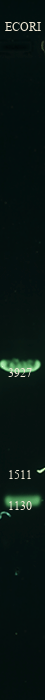

In [21]:
ECORI_lane = 'ECORI_lane.png'
AnnotateLanes(ECORI_lane, 'ECORI')
Image(filename = 'AnnotateECORI.png')

### Analysis of Extrapolation

In [22]:
#pGEM-Luc Plasmid has MW of 4931
Plasmid_bp_estimate = 3927 + 1130
print(str(math.floor(Plasmid_bp_estimate)) + ' basepairs')
print(str((Plasmid_bp_estimate - 4931)/4931 * 100) + ' % error')

5057 basepairs
2.555262624214155 % error


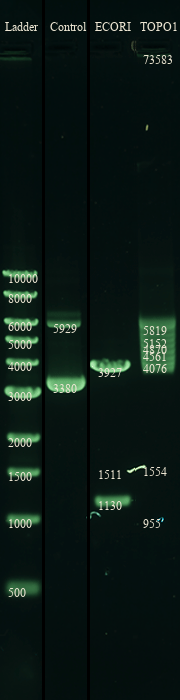

In [23]:
ladder = ImageP.open('AnnotateLADDER.png')
ladder_size = ladder.size

control = ImageP.open('AnnotateControl.png')
control_size = control.size

ecori = ImageP.open('AnnotateECORI.png')
ecori_size = ecori.size

topo1 = ImageP.open('AnnotateTOPO1.png')
topo1_size = topo1.size

new_img = ImageP.new('RGB', (4*ecori_size[0],ecori_size[1]))
new_img.paste(ladder,(0,0))
new_img.paste(control,(ecori_size[0],0))
new_img.paste(ecori,(2*ecori_size[0],0))
new_img.paste(topo1,(3*ecori_size[0],0))

new_img.save('Full_Annotated_Gel.png','PNG')
Image(filename = 'Full_Annotated_Gel.png')